In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
df = pd.read_csv('./213data.csv')
df.head()

,Speaker,Repetition,Order,Word,oaf_20,oap_20,naf_20,oaf_50,oap_50,naf_50,oaf_80,oap_80,naf_80
0,Ben,1,1.0,boot,0.070704,0.015282,0.019949,0.038959,0.003209,0.007947,0.049256,0.005915,0.000671
1,Ben,1,2.0,birm,0.072007,0.002318,-0.013097,0.035553,0.002444,0.023533,0.040436,0.001377,0.033020
2,Ben,1,3.0,bait,0.089226,0.004072,-0.016685,0.126161,0.003457,-0.023668,0.097822,0.002648,0.029912
3,Ben,1,4.0,bite,0.074309,0.002084,-0.013848,0.098021,0.002466,-0.014600,0.120178,0.003263,0.024362
4,Ben,1,5.0,beat,0.095710,0.003580,-0.025400,0.093751,0.003291,-0.026665,0.087248,0.002750,0.031569


In [4]:
df = pd.melt(df,id_vars=['Speaker','Repetition','Order','Word'])
df.head()

,Speaker,Repetition,Order,Word,variable,value
0,Ben,1,1.0,boot,oaf_20,0.070704
1,Ben,1,2.0,birm,oaf_20,0.072007
2,Ben,1,3.0,bait,oaf_20,0.089226
3,Ben,1,4.0,bite,oaf_20,0.074309
4,Ben,1,5.0,beat,oaf_20,0.095710


In [5]:
df['measurement'] = df.variable.apply(lambda x: x.split('_')[0])
df['time'] = df.variable.apply(lambda x: x.split('_')[1])
df.head()

,Speaker,Repetition,Order,Word,variable,value,measurement,time
0,Ben,1,1.0,boot,oaf_20,0.070704,oaf,20
1,Ben,1,2.0,birm,oaf_20,0.072007,oaf,20
2,Ben,1,3.0,bait,oaf_20,0.089226,oaf,20
3,Ben,1,4.0,bite,oaf_20,0.074309,oaf,20
4,Ben,1,5.0,beat,oaf_20,0.095710,oaf,20


The next cells demonstrate how to make a few common types of plots using `seaborn`: boxplots, scatterplots, lineplots.

<AxesSubplot:xlabel='Speaker', ylabel='value'>

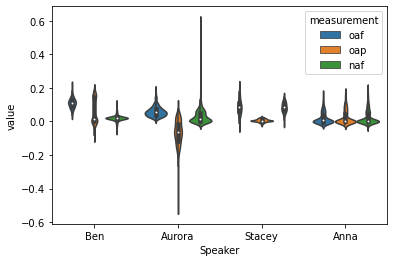

In [9]:
sns.violinplot(x='Speaker',y='value',hue='measurement',data=df)

<AxesSubplot:xlabel='Speaker', ylabel='value'>

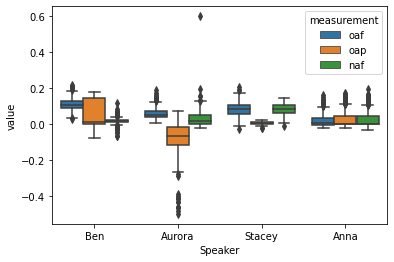

In [10]:
sns.boxplot(x='Speaker',y='value',hue='measurement',data=df)

<AxesSubplot:xlabel='time', ylabel='value'>

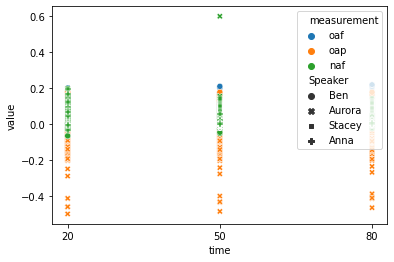

In [7]:
sns.scatterplot(x='time',y='value',data=df,hue='measurement',style='Speaker')

<AxesSubplot:xlabel='time', ylabel='value'>

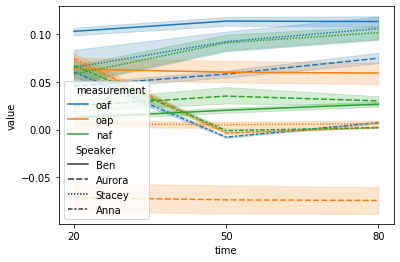

In [8]:
sns.lineplot(x='time',y='value',hue='measurement',style='Speaker',data=df)

One of the things that strikes us while looking at these figures is how much variation there is in the ranges between speakers. Part of this is just due to natural inherent variation, but some of it is going to be due to differences in the equipment, or recording conditions, and we don't want those differences to overshadow the patterns in the data, should they be there. So our first task will be to either calibrate or normalize our data. 

Calibrating the data would entail converting the existing data into real life measurements -- e.g. l/s for airflow, and mmH2O for pressure. But we don't currently have the ability to do that yet! So we'll normalize the data instead.

There are many ways to normalize the data, but what we'll try here is to 

In [11]:
lowvalues = df.groupby(['Speaker','measurement']).quantile([0.25]).reset_index()
highvalues = df.groupby(['Speaker','measurement']).quantile([0.75]).reset_index()

In [9]:
df.apply(lambda x: (x.value-float(lowvalues[(lowvalues.Speaker==x.Speaker) & (lowvalues.measurement==x.measurement)].value))/
         float(highvalues[(highvalues.Speaker==x.Speaker) & (highvalues.measurement==x.measurement)].value-
         lowvalues[(lowvalues.Speaker==x.Speaker) & (lowvalues.measurement==x.measurement)].value),
        axis=1)

0      -0.523763
1      -0.489037
2      -0.030307
3      -0.427718
4       0.142457
          ...   
4477    0.031725
4478    0.045837
4479    0.035979
4480    0.013427
4481    0.099731
Length: 4482, dtype: float64

In [12]:
dfnorm = df.copy()

dfnorm['value'] = dfnorm.apply(lambda x: (x.value-float(lowvalues[(lowvalues.Speaker==x.Speaker) & (lowvalues.measurement==x.measurement)].value))/
         float(highvalues[(highvalues.Speaker==x.Speaker) & (highvalues.measurement==x.measurement)].value-
         lowvalues[(lowvalues.Speaker==x.Speaker) & (lowvalues.measurement==x.measurement)].value),
        axis=1)

dfnorm.head()

,Speaker,Repetition,Order,Word,variable,value,measurement,time
0,Ben,1,1.0,boot,oaf_20,-0.523763,oaf,20
1,Ben,1,2.0,birm,oaf_20,-0.489037,oaf,20
2,Ben,1,3.0,bait,oaf_20,-0.030307,oaf,20
3,Ben,1,4.0,bite,oaf_20,-0.427718,oaf,20
4,Ben,1,5.0,beat,oaf_20,0.142457,oaf,20


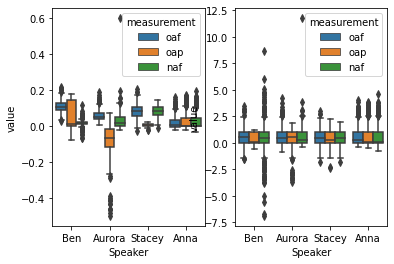

In [13]:
fig, ax =plt.subplots(1,2)

p = sns.boxplot(x='Speaker',y='value',hue='measurement',data=df, ax=ax[0])
p = sns.boxplot(x='Speaker',y='value',hue='measurement',data=dfnorm, ax=ax[1])

The vowels in our study have a few features we want to consider:
- height
- backness
- nasality (if they are in the context of a nasal coda)
- rhoticity (if they are in the context of an /ɹ/, whether that's an /ɹ/ coda or the vowel itself is rhotic)

We'll need to add these to the dataframe if we want to do any work with them!

To get these features into our dataframe, we'll define a series of dictionaries (a type of Python variable) with the relevant information, and then use them to update the dataframe.

In [14]:
# Get a list of all the words!
df.Word.unique()

array(['boot', 'birm', 'bait', 'bite', 'beat', 'bought', 'Bert', 'bout',
       'bin', 'bound', 'boon', 'boing', 'but', 'born', 'bort', 'bun',
       'boit', 'Ben', 'barn', 'bet', 'bot', 'Bart', 'bat', 'bean', 'bone',
       'bit', 'ban', 'boat', 'bomb', 'bind', 'bane', 'bart', 'bee',
       'Burt', 'beet', 'berm', 'burt', 'bing', 'bolt'], dtype=object)

In [15]:
nasality = {
    'boot': False,
    'birm': True, 
    'bait': False, 
    'bite': False, 
    'beat': False, 
    'bought': False, 
    'Bert': False, 
    'bout': False,
    'bin': True, 
    'bound': True, 
    'boon': True, 
    'boing': True, 
    'but': False, 
    'born': True, 
    'bort': False, 
    'bun': True,
    'boit': False, 
    'Ben': True, 
    'barn': True, 
    'bet': False, 
    'bot': False, 
    'Bart': False, 
    'bat': False, 
    'bean': True, 
    'bone': True,
    'bit': False, 
    'ban': True, 
    'boat': False, 
    'bomb': True, 
    'bind': True, 
    'bane': True, 
    'bart': False, 
    'bee': False,
    'Burt': False, 
    'beet': False, 
    'berm': True, 
    'burt': False, 
    'bing': True, 
    'bolt': False
}

In [16]:
dfnorm['Nasal'] = dfnorm.Word.apply(lambda x: nasality[x])
dfnorm.head()

,Speaker,Repetition,Order,Word,variable,value,measurement,time,Nasal
0,Ben,1,1.0,boot,oaf_20,-0.523763,oaf,20,False
1,Ben,1,2.0,birm,oaf_20,-0.489037,oaf,20,True
2,Ben,1,3.0,bait,oaf_20,-0.030307,oaf,20,False
3,Ben,1,4.0,bite,oaf_20,-0.427718,oaf,20,False
4,Ben,1,5.0,beat,oaf_20,0.142457,oaf,20,False


<AxesSubplot:xlabel='time', ylabel='value'>

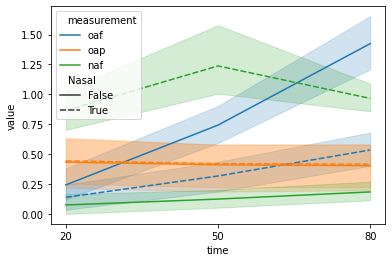

In [21]:
sns.lineplot(x='time',y='value',style='Nasal',hue='measurement',data=dfnorm[dfnorm.Speaker=='Aurora'])

In [22]:
height1 = {
    'boot': 'high',
    'birm': 'high', 
    'bait': 'mid', 
    'bite': 'low', 
    'beat': 'high', 
    'bought': 'low', 
    'Bert': 'mid', 
    'bout': 'low',
    'bin': 'high', 
    'bound': 'low', 
    'boon': 'high', 
    'boing': 'low', 
    'but': 'mid', 
    'born': 'mid', 
    'bort': 'mid', 
    'bun': 'mid',
    'boit': 'low', 
    'Ben': 'mid', 
    'barn': 'low', 
    'bet': 'mid', 
    'bot': 'low', 
    'Bart': 'low', 
    'bat': 'low', 
    'bean': 'high', 
    'bone': 'mid',
    'bit': 'high', 
    'ban': 'low', 
    'boat': 'mid', 
    'bomb': 'low', 
    'bind': 'low', 
    'bane': 'mid', 
    'bart': 'low', 
    'bee': 'high',
    'Burt': 'mid', 
    'beet': 'high', 
    'berm': 'mid', 
    'burt': 'mid', 
    'bing': 'high', 
    'bolt': 'mid'
}
height2 = {
    'boot': 'high',
    'birm': 'high', 
    'bait': 'high', 
    'bite': 'high', 
    'beat': 'high', 
    'bought': 'low', 
    'Bert': 'mid', 
    'bout': 'high',
    'bin': 'high', 
    'bound': 'high', 
    'boon': 'high', 
    'boing': 'high', 
    'but': 'mid', 
    'born': 'mid', 
    'bort': 'mid', 
    'bun': 'mid',
    'boit': 'high', 
    'Ben': 'mid', 
    'barn': 'low', 
    'bet': 'mid', 
    'bot': 'low', 
    'Bart': 'low', 
    'bat': 'low', 
    'bean': 'high', 
    'bone': 'high',
    'bit': 'high', 
    'ban': 'low', 
    'boat': 'high', 
    'bomb': 'low', 
    'bind': 'high', 
    'bane': 'high', 
    'bart': 'low', 
    'bee': 'high',
    'Burt': 'mid', 
    'beet': 'high', 
    'berm': 'mid', 
    'burt': 'mid', 
    'bing': 'high', 
    'bolt': 'mid'
}

In [23]:
dfnorm['Height1'] = dfnorm.Word.apply(lambda x: height1[x])
dfnorm['Height2'] = dfnorm.Word.apply(lambda x: height2[x])

<AxesSubplot:xlabel='time', ylabel='value'>

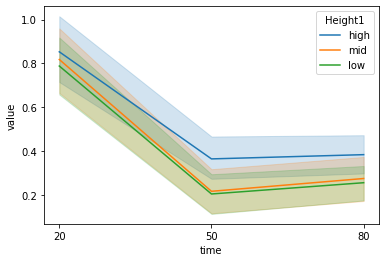

In [25]:
sns.lineplot(x='time',y='value',hue='Height1',data=dfnorm[dfnorm.measurement=='oap'])

<AxesSubplot:xlabel='time', ylabel='value'>

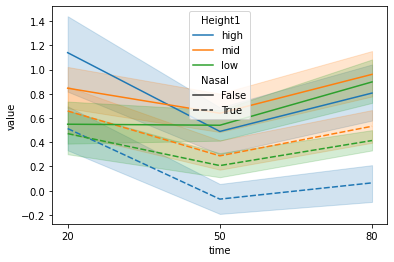

In [27]:
sns.lineplot(x='time',y='value',hue='Height1',style='Nasal',data=dfnorm[dfnorm.measurement=='oaf'])

<AxesSubplot:xlabel='time', ylabel='value'>

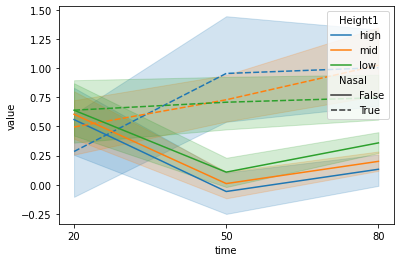

In [28]:
sns.lineplot(x='time',y='value',hue='Height1',style='Nasal',data=dfnorm[dfnorm.measurement=='naf'])

<AxesSubplot:xlabel='time', ylabel='value'>

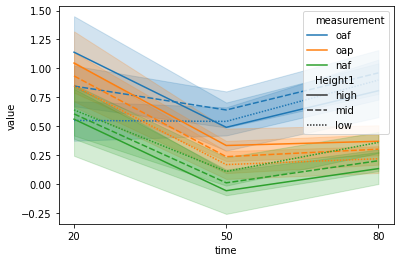

In [19]:
sns.lineplot(x='time',y='value',style='Height1',hue='measurement',data=dfnorm[dfnorm.Nasal==False])

<AxesSubplot:xlabel='time', ylabel='value'>

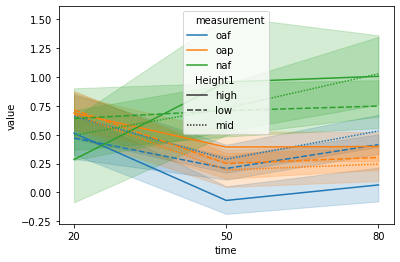

In [21]:
sns.lineplot(x='time',y='value',style='Height1',hue='measurement',data=dfnorm[dfnorm.Nasal==True])

Because English /ɹ/ mostly shows up in the orthography of the word, we can (conveniently) be a little more short/clever with how we get that into our dataframe!

In [29]:
dfnorm['R'] = dfnorm.Word.apply(lambda x: 'r' in x)
dfnorm.head()

,Speaker,Repetition,Order,Word,variable,value,measurement,time,Nasal,Height1,Height2,R
0,Ben,1,1.0,boot,oaf_20,-0.523763,oaf,20,False,high,high,False
1,Ben,1,2.0,birm,oaf_20,-0.489037,oaf,20,True,high,high,True
2,Ben,1,3.0,bait,oaf_20,-0.030307,oaf,20,False,mid,high,False
3,Ben,1,4.0,bite,oaf_20,-0.427718,oaf,20,False,low,high,False
4,Ben,1,5.0,beat,oaf_20,0.142457,oaf,20,False,high,high,False


<AxesSubplot:xlabel='time', ylabel='value'>

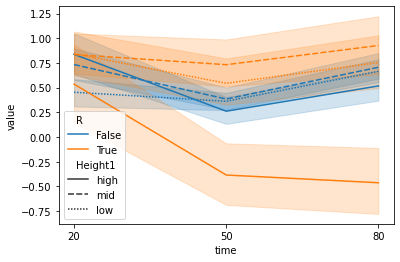

In [31]:
sns.lineplot(x='time',y='value',style='Height1',hue='R',data=dfnorm[dfnorm.measurement=='oaf'])